In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

The dataset is about forest fire in Portugal, detailed information can be found here:
http://archive.ics.uci.edu/ml/datasets/Forest+Fires

## Atribut Information

For more information, read [Cortez and Morais, 2007].
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

In [2]:
data = pd.read_csv('../dataset/forestfires.csv')

In [3]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
data.shape

(517, 13)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Data Engineering

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

In [7]:
X = data.drop(['area','X','Y'], axis = 1)
y = data['area']

In [8]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype != 'object']

In [9]:
# Preprocessing for categorical data
categorical_transformer = OrdinalEncoder()

X[categorical_cols] = categorical_transformer.fit_transform(X[categorical_cols])

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.8, 
                                                      test_size=0.2,
                                                      random_state=42)

In [11]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

X_train[numerical_cols] = numerical_transformer.fit_transform(X_train[numerical_cols])
X_valid[numerical_cols] = numerical_transformer.transform(X_valid[numerical_cols])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


# SVR

In [13]:
model = SVR()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
    'gamma' : [0.001, 0.01, 0.1, 1, 5, 10, 100],
    'epsilon' : [0.01,0.1,0.2,0.5]
}

search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5)

search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'epsilon': [0.01, 0.1, 0.2, 0.5],
                         'gamma': [0.001, 0.01, 0.1, 1, 5, 10, 100]})

In [14]:
print(search.best_params_)

{'C': 100, 'epsilon': 0.5, 'gamma': 100}


In [15]:
y_pred = search.predict(X_valid)

In [17]:
mean_squared_error(y_valid, y_pred, squared=False)

109.0373693097734

# NN

In [24]:
X_train.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
329,11.0,2.0,0.280286,-0.150282,0.810272,-0.095838,0.797602,-1.059419,0.001631,-0.067817
173,11.0,1.0,0.061652,0.217866,0.549136,-0.455434,-0.205272,-0.335215,-1.008923,-0.067817
272,1.0,5.0,0.263468,0.614919,0.435442,1.419602,0.227001,0.147588,0.001631,-0.067817
497,1.0,5.0,0.936186,1.048482,0.487669,1.419602,2.319206,-1.059419,-1.008923,-0.067817
182,3.0,3.0,-0.627884,-1.469227,-2.014816,-1.251682,-1.121692,0.509690,-1.008923,-0.067817


In [37]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(units=5, activation='relu', input_shape=[10]),
    layers.Dense(units=5, activation='tanh'),
    layers.Dense(units=1),
])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

In [40]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=500,
)

Epoch 1/500
13/13 [==============================] - 0s 8ms/step - loss: 2196.5369 - root_mean_squared_error: 46.8672 - val_loss: 12147.3027 - val_root_mean_squared_error: 110.2148
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 2191.0286 - root_mean_squared_error: 46.8084 - val_loss: 12139.2607 - val_root_mean_squared_error: 110.1783
Epoch 3/500
13/13 [==============================] - 0s 2ms/step - loss: 2186.1479 - root_mean_squared_error: 46.7563 - val_loss: 12133.0576 - val_root_mean_squared_error: 110.1502
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 2182.0464 - root_mean_squared_error: 46.7124 - val_loss: 12127.7285 - val_root_mean_squared_error: 110.1260
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 2178.6853 - root_mean_squared_error: 46.6764 - val_loss: 12122.6631 - val_root_mean_squared_error: 110.1030
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 2175.3242 - root_mean_

13/13 [==============================] - 0s 2ms/step - loss: 2116.1064 - root_mean_squared_error: 46.0012 - val_loss: 11999.0879 - val_root_mean_squared_error: 109.5404
Epoch 47/500
13/13 [==============================] - 0s 2ms/step - loss: 2115.3049 - root_mean_squared_error: 45.9924 - val_loss: 11997.6475 - val_root_mean_squared_error: 109.5338
Epoch 48/500
13/13 [==============================] - 0s 2ms/step - loss: 2114.6387 - root_mean_squared_error: 45.9852 - val_loss: 11996.1602 - val_root_mean_squared_error: 109.5270
Epoch 49/500
13/13 [==============================] - 0s 2ms/step - loss: 2113.9158 - root_mean_squared_error: 45.9773 - val_loss: 11994.6875 - val_root_mean_squared_error: 109.5203
Epoch 50/500
13/13 [==============================] - 0s 2ms/step - loss: 2113.3054 - root_mean_squared_error: 45.9707 - val_loss: 11993.1367 - val_root_mean_squared_error: 109.5132
Epoch 51/500
13/13 [==============================] - 0s 2ms/step - loss: 2112.6172 - root_mean_squared

Epoch 136/500
13/13 [==============================] - 0s 2ms/step - loss: 2077.5623 - root_mean_squared_error: 45.5803 - val_loss: 11904.8506 - val_root_mean_squared_error: 109.1094
Epoch 137/500
13/13 [==============================] - 0s 2ms/step - loss: 2077.3445 - root_mean_squared_error: 45.5779 - val_loss: 11904.0068 - val_root_mean_squared_error: 109.1055
Epoch 138/500
13/13 [==============================] - 0s 2ms/step - loss: 2077.0701 - root_mean_squared_error: 45.5749 - val_loss: 11903.2871 - val_root_mean_squared_error: 109.1022
Epoch 139/500
13/13 [==============================] - 0s 2ms/step - loss: 2076.7815 - root_mean_squared_error: 45.5717 - val_loss: 11902.6523 - val_root_mean_squared_error: 109.0993
Epoch 140/500
13/13 [==============================] - 0s 2ms/step - loss: 2076.5806 - root_mean_squared_error: 45.5695 - val_loss: 11901.8799 - val_root_mean_squared_error: 109.0957
Epoch 141/500
13/13 [==============================] - 0s 2ms/step - loss: 2076.2336 

Epoch 181/500
13/13 [==============================] - 0s 2ms/step - loss: 2066.9600 - root_mean_squared_error: 45.4638 - val_loss: 11876.4961 - val_root_mean_squared_error: 108.9793
Epoch 182/500
13/13 [==============================] - 0s 2ms/step - loss: 2066.7280 - root_mean_squared_error: 45.4613 - val_loss: 11876.0273 - val_root_mean_squared_error: 108.9772
Epoch 183/500
13/13 [==============================] - 0s 2ms/step - loss: 2066.4802 - root_mean_squared_error: 45.4586 - val_loss: 11875.3652 - val_root_mean_squared_error: 108.9742
Epoch 184/500
13/13 [==============================] - 0s 2ms/step - loss: 2066.3887 - root_mean_squared_error: 45.4575 - val_loss: 11874.8867 - val_root_mean_squared_error: 108.9720
Epoch 185/500
13/13 [==============================] - 0s 2ms/step - loss: 2066.1101 - root_mean_squared_error: 45.4545 - val_loss: 11874.4072 - val_root_mean_squared_error: 108.9698
Epoch 186/500
13/13 [==============================] - 0s 3ms/step - loss: 2066.0288 

Epoch 270/500
13/13 [==============================] - 0s 2ms/step - loss: 2048.9934 - root_mean_squared_error: 45.2658 - val_loss: 11822.6260 - val_root_mean_squared_error: 108.7319
Epoch 271/500
13/13 [==============================] - 0s 2ms/step - loss: 2048.6917 - root_mean_squared_error: 45.2625 - val_loss: 11822.2900 - val_root_mean_squared_error: 108.7304
Epoch 272/500
13/13 [==============================] - 0s 2ms/step - loss: 2048.7268 - root_mean_squared_error: 45.2629 - val_loss: 11820.8896 - val_root_mean_squared_error: 108.7239
Epoch 273/500
13/13 [==============================] - 0s 2ms/step - loss: 2048.1958 - root_mean_squared_error: 45.2570 - val_loss: 11821.0713 - val_root_mean_squared_error: 108.7247
Epoch 274/500
13/13 [==============================] - 0s 2ms/step - loss: 2048.0981 - root_mean_squared_error: 45.2559 - val_loss: 11820.7021 - val_root_mean_squared_error: 108.7231
Epoch 275/500
13/13 [==============================] - 0s 2ms/step - loss: 2047.7754 

Epoch 315/500
13/13 [==============================] - 0s 2ms/step - loss: 2038.2784 - root_mean_squared_error: 45.1473 - val_loss: 11794.2744 - val_root_mean_squared_error: 108.6014
Epoch 316/500
13/13 [==============================] - 0s 2ms/step - loss: 2038.0396 - root_mean_squared_error: 45.1446 - val_loss: 11793.5088 - val_root_mean_squared_error: 108.5979
Epoch 317/500
13/13 [==============================] - 0s 2ms/step - loss: 2037.9001 - root_mean_squared_error: 45.1431 - val_loss: 11792.7236 - val_root_mean_squared_error: 108.5943
Epoch 318/500
13/13 [==============================] - 0s 2ms/step - loss: 2037.8566 - root_mean_squared_error: 45.1426 - val_loss: 11791.9688 - val_root_mean_squared_error: 108.5908
Epoch 319/500
13/13 [==============================] - 0s 2ms/step - loss: 2037.3119 - root_mean_squared_error: 45.1366 - val_loss: 11791.5098 - val_root_mean_squared_error: 108.5887
Epoch 320/500
13/13 [==============================] - 0s 2ms/step - loss: 2037.1343 

Epoch 360/500
13/13 [==============================] - 0s 2ms/step - loss: 2028.0776 - root_mean_squared_error: 45.0342 - val_loss: 11762.5352 - val_root_mean_squared_error: 108.4552
Epoch 361/500
13/13 [==============================] - 0s 2ms/step - loss: 2027.7108 - root_mean_squared_error: 45.0301 - val_loss: 11762.0732 - val_root_mean_squared_error: 108.4531
Epoch 362/500
13/13 [==============================] - 0s 2ms/step - loss: 2027.5128 - root_mean_squared_error: 45.0279 - val_loss: 11761.3574 - val_root_mean_squared_error: 108.4498
Epoch 363/500
13/13 [==============================] - 0s 2ms/step - loss: 2027.2848 - root_mean_squared_error: 45.0254 - val_loss: 11760.6152 - val_root_mean_squared_error: 108.4464
Epoch 364/500
13/13 [==============================] - 0s 2ms/step - loss: 2026.9496 - root_mean_squared_error: 45.0217 - val_loss: 11759.8789 - val_root_mean_squared_error: 108.4430
Epoch 365/500
13/13 [==============================] - 0s 2ms/step - loss: 2026.8564 

Epoch 405/500
13/13 [==============================] - 0s 2ms/step - loss: 2018.2739 - root_mean_squared_error: 44.9252 - val_loss: 11734.1445 - val_root_mean_squared_error: 108.3243
Epoch 406/500
13/13 [==============================] - 0s 2ms/step - loss: 2018.2070 - root_mean_squared_error: 44.9245 - val_loss: 11733.9082 - val_root_mean_squared_error: 108.3232
Epoch 407/500
13/13 [==============================] - 0s 2ms/step - loss: 2017.8942 - root_mean_squared_error: 44.9210 - val_loss: 11733.0645 - val_root_mean_squared_error: 108.3193
Epoch 408/500
13/13 [==============================] - 0s 2ms/step - loss: 2017.6604 - root_mean_squared_error: 44.9184 - val_loss: 11732.5957 - val_root_mean_squared_error: 108.3171
Epoch 409/500
13/13 [==============================] - 0s 2ms/step - loss: 2017.4840 - root_mean_squared_error: 44.9164 - val_loss: 11732.0508 - val_root_mean_squared_error: 108.3146
Epoch 410/500
13/13 [==============================] - 0s 2ms/step - loss: 2017.3605 

Epoch 450/500
13/13 [==============================] - 0s 2ms/step - loss: 2008.6274 - root_mean_squared_error: 44.8177 - val_loss: 11711.5586 - val_root_mean_squared_error: 108.2200
Epoch 451/500
13/13 [==============================] - 0s 2ms/step - loss: 2008.4036 - root_mean_squared_error: 44.8152 - val_loss: 11711.2207 - val_root_mean_squared_error: 108.2184
Epoch 452/500
13/13 [==============================] - 0s 2ms/step - loss: 2008.3301 - root_mean_squared_error: 44.8144 - val_loss: 11710.6611 - val_root_mean_squared_error: 108.2158
Epoch 453/500
13/13 [==============================] - 0s 2ms/step - loss: 2007.8398 - root_mean_squared_error: 44.8089 - val_loss: 11710.2510 - val_root_mean_squared_error: 108.2139
Epoch 454/500
13/13 [==============================] - 0s 2ms/step - loss: 2007.9642 - root_mean_squared_error: 44.8103 - val_loss: 11709.7549 - val_root_mean_squared_error: 108.2116
Epoch 455/500
13/13 [==============================] - 0s 2ms/step - loss: 2007.7698 

Epoch 495/500
13/13 [==============================] - 0s 2ms/step - loss: 1999.6814 - root_mean_squared_error: 44.7178 - val_loss: 11688.9199 - val_root_mean_squared_error: 108.1153
Epoch 496/500
13/13 [==============================] - 0s 2ms/step - loss: 1999.0430 - root_mean_squared_error: 44.7107 - val_loss: 11688.3350 - val_root_mean_squared_error: 108.1126
Epoch 497/500
13/13 [==============================] - 0s 2ms/step - loss: 1998.6984 - root_mean_squared_error: 44.7068 - val_loss: 11688.0928 - val_root_mean_squared_error: 108.1115
Epoch 498/500
13/13 [==============================] - 0s 3ms/step - loss: 1998.5580 - root_mean_squared_error: 44.7052 - val_loss: 11687.8076 - val_root_mean_squared_error: 108.1102
Epoch 499/500
13/13 [==============================] - 0s 2ms/step - loss: 1998.3273 - root_mean_squared_error: 44.7027 - val_loss: 11687.3115 - val_root_mean_squared_error: 108.1079
Epoch 500/500
13/13 [==============================] - 0s 2ms/step - loss: 1998.2562 

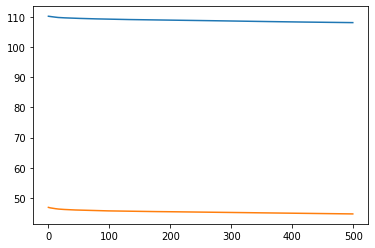

In [41]:
history_df = pd.DataFrame(history.history)
history_df['val_root_mean_squared_error'].plot();
history_df['root_mean_squared_error'].plot();

In [42]:
model.evaluate(X_valid, y_valid, verbose=False)

[11686.169921875, 108.10259246826172]

---